In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import ast

import warnings
warnings.filterwarnings('ignore')

In [2]:
# Load the data
df = pd.read_csv('data/faers_filtered_adalimumab_2020-2024_grouped.csv')

In [3]:
df.isna().sum() / len(df) * 100

primaryid       0.000000
caseid          0.000000
caseversion     0.000000
event_dt       60.442913
init_fda_dt     0.000000
fda_dt          0.000000
age            41.963818
age_cod        41.963498
age_grp        88.897394
sex            11.049600
wt             69.829788
wt_cod         69.829788
rept_dt         0.003843
occp_cod        2.431232
seq             0.000000
role_cod        0.000000
drugname        0.000000
prod_ai         0.000000
route           7.668262
dose_vbm       42.888622
dose_amt       51.635581
dose_unit      49.562740
dose_form      31.233536
dose_freq      76.679899
indi_pt        29.183755
outc_cod       20.976304
pt              0.000000
start_dt       68.656609
end_dt         87.989565
dtype: float64

In [4]:
# Drop 'event_dt', 'wt', 'wt_cod', 'start_dt', 'end_dt' columns
data = df.drop(columns=['event_dt', 'wt', 'wt_cod', 'start_dt', 'end_dt'])

In [5]:
# Lowercase 
data = data.apply(lambda x: x.str.lower() if x.dtype == "object" else x)

In [6]:
# Check for duplicates
data.duplicated().sum()

np.int64(554)

In [7]:
# Drop duplicates
data = data.drop_duplicates()

In [8]:
data['primaryid'].nunique(), data['caseid'].nunique()

(299225, 257274)

In [9]:
pd.set_option('display.max_columns', None)

# Display the first 5 rows
data.head(5)

,primaryid,caseid,caseversion,init_fda_dt,fda_dt,age,age_cod,age_grp,sex,rept_dt,occp_cod,seq,role_cod,drugname,prod_ai,route,dose_vbm,dose_amt,dose_unit,dose_form,dose_freq,indi_pt,outc_cod,pt
0,100735935,10073593,5,20140411,20200326,55.0,yr,NaN,f,20200326.0,cn,1,ps,humira,adalimumab,subcutaneous,NaN,40.0,mg,solution for injection in pre-filled syringe,qow,rheumatoid arthritis,ot,"['arterial occlusive disease', 'carotid artery..."
1,100735935,10073593,5,20140411,20200326,55.0,yr,NaN,f,20200326.0,cn,1,ps,humira,adalimumab,subcutaneous,NaN,40.0,mg,solution for injection in pre-filled syringe,qow,rheumatoid arthritis,ho,"['arterial occlusive disease', 'carotid artery..."
2,100735935,10073593,5,20140411,20200326,55.0,yr,NaN,f,20200326.0,cn,2,ss,humira,adalimumab,subcutaneous,NaN,40.0,mg,solution for injection,qow,NaN,ot,"['arterial occlusive disease', 'carotid artery..."
3,100735935,10073593,5,20140411,20200326,55.0,yr,NaN,f,20200326.0,cn,2,ss,humira,adalimumab,subcutaneous,NaN,40.0,mg,solution for injection,qow,NaN,ho,"['arterial occlusive disease', 'carotid artery..."
4,102775337,10277533,7,20140703,20200124,40.0,yr,NaN,m,20200124.0,md,1,ps,humira,adalimumab,subcutaneous,NaN,40.0,mg,solution for injection,qow,crohn's disease,ho,"['anal incontinence', 'constipation', 'defaeca..."


### 1. Missing values in indi_pt, dose_form, dose_amt, dose_unit, dose_freq

In [10]:
# Drop all missing values in 'indi_pt' column
indi_pt_missing = data.loc[data['indi_pt'].isnull() | 
                             (data['indi_pt'] == 'product used for unknown indication')]

mask = data.isin(indi_pt_missing.to_dict(orient='list')).all(axis=1)
data_2 = data[~mask]

In [11]:
# Drop all missing dosage values
dose_missing = data_2.loc[
    ((data_2['dose_form'] == 'unknown') | data_2['dose_form'].isna()) & 
    data_2[['dose_amt', 'dose_unit', 'dose_freq']].isna().all(axis=1)
]
mask = data_2.isin(dose_missing.to_dict(orient='list')).all(axis=1)
data_3 = data_2[~mask]

### 2. Date in init_fda_dt, fda_dt, rept_dt

In [12]:
# Convert 'init_fda_dt' and 'fda_dt' to datetime
data_3['init_fda_dt'] = pd.to_datetime(data_3['init_fda_dt'].astype(str), format='%Y%m%d')
data_3['init_fda_dt'] = data_3['init_fda_dt'].dt.strftime('%Y-%m-%d')

data_3['fda_dt'] = pd.to_datetime(data_3['fda_dt'].astype(str), format='%Y%m%d')
data_3['fda_dt'] = data_3['fda_dt'].dt.strftime('%Y-%m-%d')

data_3['rept_dt'] = data_3['rept_dt'].astype(str).str.replace(r'\.0$', '', regex=True) # Remove trailing .0
data_3['rept_dt'] = pd.to_datetime(data_3['rept_dt'].astype(str), format='%Y%m%d', errors='coerce')
data_3['rept_dt'] = data_3['rept_dt'].dt.strftime('%Y-%m-%d')

In [13]:
# Replace missing dates in 'rept_dt' with 'fda_dt'
data_3['rept_dt'] = data_3['rept_dt'].fillna(data_3['fda_dt'])

In [14]:
# Get the number of reports per year
data_3['rept_yr'] = pd.to_datetime(data_3['rept_dt']).dt.year

# Drop 'rept_dt' column
data_3 = data_3.drop(columns=['rept_dt'])

In [15]:
data_3['rept_yr'].value_counts()

rept_yr
2022    80394
2024    63998
2023    60615
2020    56084
2021    48224
2019      129
2025       14
2017        8
2018        6
2016        3
2008        1
2012        1
Name: count, dtype: int64

In [16]:
# Drop all rports before 2020
data_3 = data_3[data_3['rept_yr'] >= 2020]

### 3. Missing values in occp_cod, sex, outc_cod

In [17]:
# Function to replace 'unk' values with the ratio of the remaining values
def replace_unk(data, column, unknown='unk'):
    # Fill missing values with value
    data[column] = data[column].fillna(unknown)

    # Count
    val_count = data[column].value_counts()
    unk_count = val_count[unknown]
    val_count = val_count.drop(unknown)
    val_ratio = val_count / val_count.sum()

    # Replace 'unk' values with the ratio of the remaining values
    replacement_val = np.random.choice(val_ratio.index, size=unk_count, p=val_ratio.values)

    unk_index = data.loc[data[column] == unknown].index
    data.loc[unk_index, column] = replacement_val

    return data

In [18]:
data_3[['occp_cod', 'sex', 'outc_cod']].isna().sum() / len(data_3) * 100

occp_cod     3.958892
sex          8.256904
outc_cod    27.491441
dtype: float64

In [19]:
data_3['occp_cod'].value_counts()

occp_cod
cn    177676
hp     82381
md     34428
ph      2522
lw        76
Name: count, dtype: int64

In [20]:
# Fill missing values in the 'occp_cod' column
data_3 = replace_unk(data_3, 'occp_cod', 'unk')

In [21]:
data_3['sex'].value_counts()

sex
f      203106
m       80658
unk        24
Name: count, dtype: int64

In [22]:
# Fill missing values in the 'sex' column
data_3 = replace_unk(data_3, 'sex', 'unk')

In [23]:
data_3['outc_cod'].value_counts()

outc_cod
ot    119640
ho     59460
ds     16128
de     14762
lt     11403
ca      2714
ri       183
Name: count, dtype: int64

In [24]:
# Fill missing values in the 'outc_cod' column
data_3 = replace_unk(data_3, 'outc_cod', 'unk')

### 4. Drop contaminant and interacting in role_cod

In [25]:
# Drop 'c' and 'i' rows in role_cod
data_3 = data_3[~data_3['role_cod'].isin(['c', 'i'])]

### 5. Synchronize values in age, age_cod, age_grp

In [26]:
data_3[['age', 'age_cod', 'age_grp']].isna().sum() / len(data_3) * 100

age        44.025425
age_cod    44.025095
age_grp    92.140000
dtype: float64

In [27]:
data_3[['age', 'age_cod', 'age_grp']].head(5)

,age,age_cod,age_grp
0,55.0,yr,NaN
1,55.0,yr,NaN
4,40.0,yr,NaN
5,40.0,yr,NaN
11,NaN,NaN,NaN


In [28]:
age_list = ['age', 'age_cod', 'age_grp']
for col in age_list:
    print(data_3[col].value_counts())
    print()

age
44.0       16342
43.0       11377
40.0        7794
59.0        4930
63.0        4296
           ...  
20602.0        4
22728.0        2
100.0          1
16261.0        1
99.0           1
Name: count, Length: 107, dtype: int64

age_cod
yr     169700
dy         65
dec        62
mon        27
wk         21
hr          1
Name: count, dtype: int64

age_grp
a    18435
e     4419
t      461
c      308
n      198
i       33
Name: count, dtype: int64



In [29]:
# Convert age values to 'year'-based unit
conversion_age = {
    'dec': 10,
    'yr': 1,
    'mon': 1/12,
    'wk': 1/52,
    'dy': 1/365,
    'hr': 1/8760
}

data_3['age'] *= data_3['age_cod'].replace(conversion_age).astype(float)
data_3['age'] = data_3['age'].round(1)

In [30]:
# Fill missing values in the 'age_grp' column based on the 'age' column
def map_age_group(conversion_grp, age):

    for i in range(len(conversion_grp['min_yr'])):
        if conversion_grp['min_yr'][i] <= age < conversion_grp['max_yr'][i]:
            return conversion_grp['age_grp'][i]
        
    return None

conversion_grp = {
    'age_grp': ['n', 'i', 'c', 't', 'a', 'e'],
    'min_yr': [0.0, 0.1, 2.0, 12.0, 18.0, 65.0],
    'max_yr': [0.1, 2.0, 12.0, 18.0, 65.0, 120.0]
}

data_3['age_grp'] = data_3.apply(
    lambda row: map_age_group(conversion_grp, row['age']) if pd.notnull(row['age']) and pd.isnull(row['age_grp']) else row['age_grp'],
    axis=1
)

In [31]:
# Drop 'age_cod' column
data_3 = data_3.drop(columns='age_cod')

In [32]:
# Fill missing values in the 'age_grp' column
data_3 = replace_unk(data_3, 'age_grp', 'u')

In [33]:
def replace_rand_age(age_grp, conversion_grp):

    # Return a random age within the range of the age group
    for i in range(len(conversion_grp['age_grp'])):
        if conversion_grp['age_grp'][i] == age_grp:
            return round(np.random.uniform(conversion_grp['min_yr'][i], conversion_grp['max_yr'][i]), 1)

    return None

data_3['age'] = data_3.apply(
    lambda row: replace_rand_age(row['age_grp'], conversion_grp) if pd.isnull(row['age']) else row['age'],
    axis=1
)

### 6. Synchronize values in drugname, prod_ai

In [34]:
data_3['prod_ai'].value_counts()

prod_ai
adalimumab                                      274902
adalimumab\isopropyl alcohol                     13731
adalimumab-adaz                                   6703
adalimumab-afzb                                   3463
adalimumab-fkjp                                   2115
adalimumab-aaty                                   1133
adalimumab-ryvk                                    586
adalimumab-bwwd                                    398
adalimumab-atto                                    345
adalimumab-aqvh                                     49
adalimumab-aacf                                     40
adalimumab-adbm                                     16
adalimumab\adalimumab-aacf\isopropyl alcohol         5
Name: count, dtype: int64

In [35]:
data_3[data_3['prod_ai'] == 'adalimumab-adaz']['drugname'].value_counts()

drugname
hyrimoz            6690
adalimumab-adaz      13
Name: count, dtype: int64

In [36]:
data_3[data_3['prod_ai'] == 'adalimumab-afzb']['drugname'].value_counts()

drugname
abrilada    3463
Name: count, dtype: int64

In [37]:
data_3[data_3['prod_ai'] == 'adalimumab-fkjp']['drugname'].value_counts()

drugname
hulio              2113
adalimumab-fkjp       2
Name: count, dtype: int64

In [38]:
data_3[data_3['prod_ai'] == 'adalimumab-aaty']['drugname'].value_counts()

drugname
yuflyma            1047
adalimumab-aaty      86
Name: count, dtype: int64

In [39]:
data_3[data_3['prod_ai'] == 'adalimumab-ryvk']['drugname'].value_counts()

drugname
simlandi           584
adalimumab-ryvk      2
Name: count, dtype: int64

In [40]:
data_3[data_3['prod_ai'] == 'adalimumab-bwwd']['drugname'].value_counts()

drugname
hadlima            394
adalimumab-bwwd      4
Name: count, dtype: int64

In [41]:
data_3[data_3['prod_ai'] == 'adalimumab-atto']['drugname'].value_counts()

drugname
amjevita    345
Name: count, dtype: int64

In [42]:
data_3[data_3['prod_ai'] == 'adalimumab-aqvh']['drugname'].value_counts()

drugname
yusimry            32
adalimumab-aqvh    17
Name: count, dtype: int64

In [43]:
data_3[data_3['prod_ai'] == 'adalimumab-aacf']['drugname'].value_counts()

drugname
idacio             39
adalimumab-aacf     1
Name: count, dtype: int64

In [44]:
data_3[data_3['prod_ai'] == 'adalimumab-adbm']['drugname'].value_counts()

drugname
cyltezo            15
adalimumab-adbm     1
Name: count, dtype: int64

In [45]:
data_3[data_3['prod_ai'] == r'adalimumab\adalimumab-aacf\isopropyl alcohol']['drugname'].value_counts()

drugname
adalimumab-aacf    5
Name: count, dtype: int64

In [46]:
data_3[data_3['prod_ai'] == 'adalimumab\isopropyl alcohol']['drugname'].value_counts()

drugname
adalimumab    13731
Name: count, dtype: int64

In [47]:
data_3['drugname'].value_counts()

drugname
humira                                                         245753
adalimumab                                                      38674
hyrimoz                                                          6690
abrilada                                                         3463
imraldi                                                          2925
hulio                                                            2113
amgevita                                                         1248
yuflyma                                                          1047
simlandi                                                          584
hadlima                                                           394
amjevita                                                          345
adalimumab-aaty                                                    86
idacio                                                             39
yusimry                                                            32
adalimumab-

In [48]:
# Replace the value drugname with its key
drugname = {
    'humera': 'humira',
    'humira ac': 'humira',
    'adalimumab-atto': 'amjevita',
    'adalimumab-bwwd': 'hadlima',
    'adalimumab-adbm': 'cyltezo',
    'adalimumab-fkjp': 'hulio',
    'adalimumab-adaz': 'hyrimoz',
    'adalimumab-afzb': 'abrilada',
    'adalimumab-aqvh': 'yusimry',
    'adalimumab-aacf': 'idacio',
    'adalimumab-aaty': 'yuflyma',
    'adalimumab-ryvk': 'simlandi',
}

data_3['drugname'] = data_3['drugname'].replace(drugname)

In [49]:
data_3['drugname'].value_counts()

drugname
humira                                                         245758
adalimumab                                                      38674
hyrimoz                                                          6703
abrilada                                                         3463
imraldi                                                          2925
hulio                                                            2115
amgevita                                                         1248
yuflyma                                                          1133
simlandi                                                          586
hadlima                                                           398
amjevita                                                          345
yusimry                                                            49
idacio                                                             45
cyltezo                                                            16
adalimumab 

In [50]:
# Replace all values out of the druglist with 'adalimumab'
druglist = ['humira', 'amjevita', 'hadlima', 'cyltezo', 'hulio', 'hyrimoz', 'abrilada', 
            'yusimry', 'idacio', 'yuflyma', 'simlandi', 'imraldi', 'amgevita', 'solymbic', 'dalibra']

data_3['drugname'] = data_3['drugname'].apply(lambda x: x if any(word in druglist for word in x.split()) else 'adalimumab')

In [51]:
# Replace the value prod_ai with its key
prod_ai_name = {
    r'adalimumab\adalimumab-aacf\isopropyl alcohol': 'adalimumab-aacf',
    'adalimumab\isopropyl alcohol': 'adalimumab'
}

data_3['prod_ai'] = data_3['prod_ai'].replace(prod_ai_name)

### 7. Missing values in route

In [52]:
data_3['route'].isna().sum() / len(data_3) * 100

np.float64(2.0979550951279466)

In [53]:
data_3['route'].value_counts()

route
subcutaneous                             272962
unknown                                   18303
oral                                       1746
sunconjunctival                            1065
transplacental                              998
intravenous (not otherwise specified)       923
other                                       358
intramuscular                               199
cutaneous                                   135
subcutaneous use                            109
subconjunctival                              86
parenteral                                   71
intravenous drip                             37
intravenous bolus                            25
subdermal                                    21
transmammary                                 21
sublingual                                   17
intra corpus cavernosum                      11
intradiscal (intraspinal)                     8
oral use                                      6
topical                           

In [ ]:
# Remove word 'use' from the column 'route'
data_3['route'] = data_3['route'].str.replace('sunconjunctival', 'subconjunctival')
data_3['route'] = data_3['route'].str.replace(' use', '')
data_3['route'] = data_3['route'].str.replace('sc', 'subcutaneous')
data_3['route'] = data_3['route'].str.replace('other', 'unknown')

# Fill missing values in the 'route' column
data_3['route'] = data_3['route'].fillna('unknown')

In [55]:
for drug in druglist:
    # Get value counts of known routes
    route_counts = data_3[data_3['drugname'] == drug]['route'].value_counts()
    
    if 'unknown' in route_counts:
        unknown_count = route_counts['unknown']
        route_counts = route_counts.drop('unknown')  # Remove unknowns for ratio calculation
        
        if not route_counts.empty:
            # Normalize existing values to get proportions
            route_ratios = route_counts / route_counts.sum()
            
            # Generate a new list of replacement values based on the ratio
            replacement_values = np.random.choice(
                route_ratios.index, size=unknown_count, p=route_ratios.values
            )
            
            # Replace 'unknown' with sampled values
            unknown_indices = data_3[(data_3['drugname'] == drug) & (data_3['route'] == 'unknown')].index
            data_3.loc[unknown_indices, 'route'] = replacement_values

        else:
            unknown_indices = data_3[(data_3['drugname'] == drug) & (data_3['route'] == 'unknown')].index
            data_3.loc[unknown_indices, 'route'] = 'subcutaneous'

### 8. Missing values in 'dose_vbm', 'dose_amt', 'dose_unit', 'dose_form', 'dose_freq'

In [56]:
data_3[['dose_vbm', 'dose_amt', 'dose_unit', 'dose_form', 'dose_freq']].isna().sum() / len(data_3) * 100

dose_vbm     43.321603
dose_amt     40.063792
dose_unit    37.215226
dose_form    15.286702
dose_freq    66.762882
dtype: float64

In [57]:
data_3[['dose_vbm', 'dose_amt', 'dose_unit', 'dose_form', 'dose_freq']].head(5)

,dose_vbm,dose_amt,dose_unit,dose_form,dose_freq
0,NaN,40.0,mg,solution for injection in pre-filled syringe,qow
1,NaN,40.0,mg,solution for injection in pre-filled syringe,qow
4,NaN,40.0,mg,solution for injection,qow
5,NaN,40.0,mg,solution for injection,qow
11,"40 mg, ev 2 weeks(qow)",40.0,mg,solution for injection in pre-filled pen,qow


In [58]:
data_3['dose_vbm'].value_counts()

dose_vbm
citrate free                              27786
unk                                       14761
40 mg                                     14056
40 milligram                              11002
frequency : every other week;?             9633
                                          ...  
1 df, every 10 days                           1
80mg week 0 then 40mg q 2 weeks               1
day 1;                                        1
40 mg varannan vecka                          1
24 milligram/sq. meter/every two weeks        1
Name: count, Length: 13620, dtype: int64

In [59]:
# Synonymize words in the 'dose_vbm' column
data_3['dose_vbm'] = data_3['dose_vbm'].str.replace('milligram', 'mg', regex=False)
data_3['dose_vbm'] = data_3['dose_vbm'].str.replace('cf', 'citrate free', regex=False)
data_3['dose_vbm'] = data_3['dose_vbm'].str.replace(r'[;?]', ' ', regex=True).str.strip()  # Remove ; and ? 

# Fill missing values in the 'dose_vbm' column
data_3['dose_vbm'] = data_3['dose_vbm'].str.replace('unk', 'unknown', regex=False)
data_3['dose_vbm'] = data_3['dose_vbm'].fillna('unknown')

In [60]:
data_3['dose_amt'].value_counts()

dose_amt
40.0     162162
80.0       7086
160.0      3797
4.0        3245
400.0      2030
          ...  
260.0         1
440.0         1
82.0          1
360.0         1
600.0         1
Name: count, Length: 67, dtype: int64

In [61]:
# Fill missing values in the 'dose_amt' column
data_3['dose_amt'] = data_3['dose_amt'].fillna(-1)

In [62]:
data_3['dose_unit'].value_counts()

dose_unit
mg         188915
df            675
mg/ml         407
ml            162
ug             80
mg/kg          79
gm             70
mbq            64
mg/m**2        27
mci            18
meq            11
mg/mg          10
g               9
ng              5
tot             4
iu              2
mmol            2
kg              1
ugm/hr          1
iu/kg           1
Name: count, dtype: int64

In [63]:
# Fill missing values in the 'dose_unit' column
data_3['dose_unit'] = data_3['dose_unit'].fillna('unknown')

In [64]:
data_3['dose_form'].value_counts()

dose_form
solution for injection in pre-filled pen        141940
solution for injection                           60830
injection                                        15354
solution for injection in pre-filled syringe     14613
solution                                         10210
                                                 ...  
solution for injection in prefilled pen              1
poultice                                             1
kit for radiopharmaceutical preparation              1
injectable solution in pre-filled pen                1
elixir                                               1
Name: count, Length: 120, dtype: int64

In [65]:
# Fill missing values in the 'dose_form' column
data_3['dose_form'] = data_3['dose_form'].fillna('unknown')

In [66]:
data_3['dose_freq'].value_counts()

dose_freq
qow           76590
/wk           15014
qw             2960
999            2904
qd              946
ud              587
biw             496
/month          407
q3w             342
/cycle          196
qod             170
bid             111
1x               39
/sec             37
qm               19
tiw              14
q12h             11
/yr               7
qid               5
prn               5
/trimester        3
tid               2
hs                1
pc                1
q8h               1
q4h               1
/min              1
Name: count, dtype: int64

In [67]:
# Fill missing values in the 'dose_freq' column
data_3['dose_freq'] = data_3['dose_freq'].str.replace('999', 'unknown', regex=False)
data_3['dose_freq'] = data_3['dose_freq'].fillna('unknown')

### 9. List in pt

In [68]:
# Convert string representation of list into actual list in 'pt' column
data_3['pt'] = data_3['pt'].apply(ast.literal_eval)

In [69]:
# Save data
data_3.to_csv('data/faers_adalimumab_2020-2024_grouped_cleaned.csv', index=False)

In [70]:
pts = [adverse_event for sublist in data_3['pt'] for adverse_event in sublist]

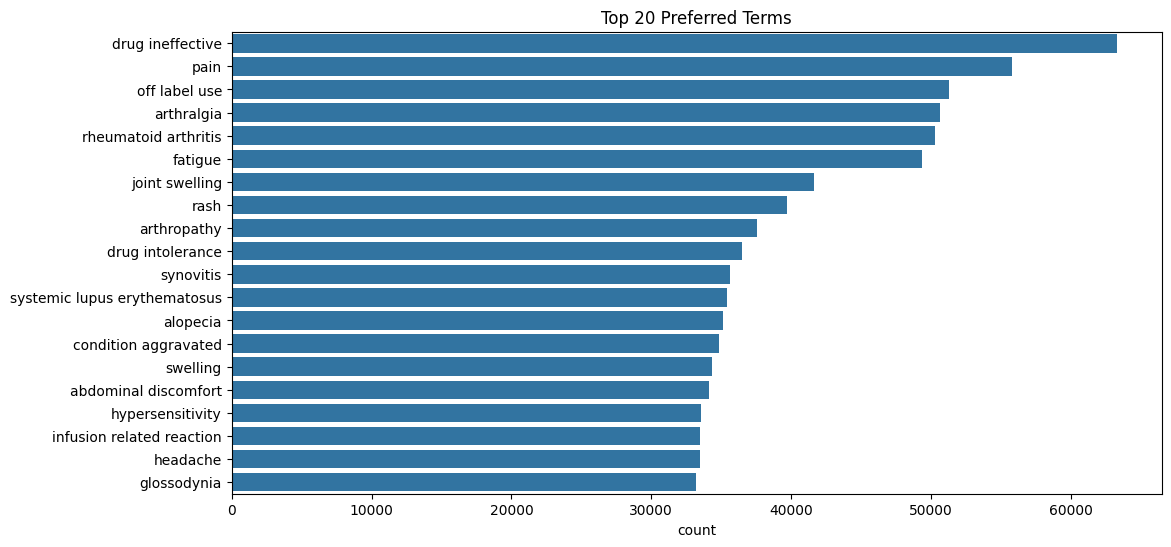

In [71]:
# Plot the distribution of the top 20 preferred terms
plt.figure(figsize=(12, 6))
sns.countplot(y=pts, order=pd.Series(pts).value_counts().index[:20])
plt.title('Top 20 Preferred Terms')
plt.show()

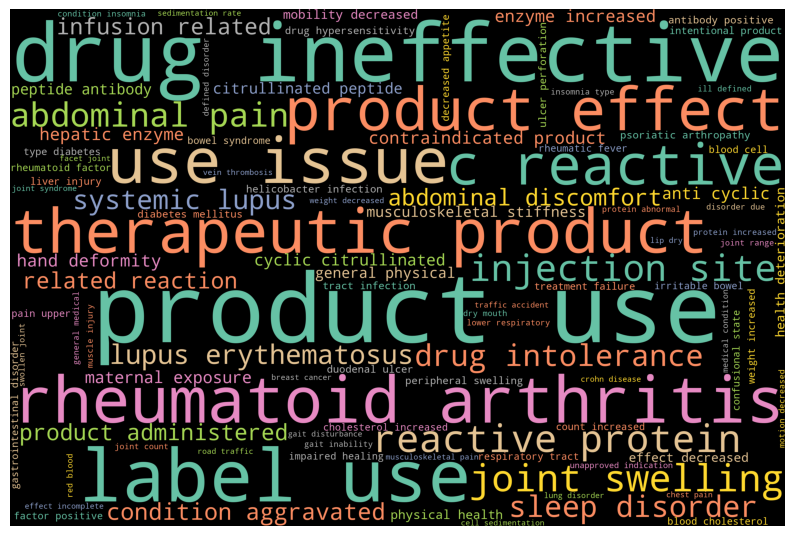

In [72]:
from wordcloud import WordCloud
# Word cloud 
word_list = ' '.join(pts)
wordcloud_pts = WordCloud(
    width=3000,
    height=2000,
    colormap='Set2',
    max_words=100,
    random_state=42
).generate(word_list)

# Display
plt.figure(figsize=(10, 10))
plt.imshow(wordcloud_pts)
plt.axis('off')
plt.show()

### 10. Mapping pt to SOC (System Organ Classes)

In [73]:
# Explode the 'pt' column to create a new row for each preferred term
data_4 = data_3.explode('pt', ignore_index=True)

In [74]:
# Dictionary of System Organ Classes (SOCs) and their corresponding keywords
SOCs_1 = {
    'General disorders and administration site conditions': ['device', 'therapy', 'therapeutic', 'site', 'adverse', 'event', 'hospitalisation', 'pyrexia', 'malaise', 'mobility', 'healing', 'fatigue', 
                                                             'ineffective', 'health', 'asthenia', 'independence', 'breakthrough', 'event', 'weather', 'infusion', 'chills', 'sick', 'life', 'concomitant'],
    'Product issues': ['product', 'label', 'labelled', 'manufacturing'],
    'Surgical and medical procedures': ['surgery', 'surgical', 'operation', 'procedure', 'drainage', 'implant', 'implantation', 'implantable', 'placement', 'replacement', 'repair', 'bypass', 
                                        'insertion', 'removal', 'catheterisation', 'angioplasty', 'aesthesia', 'application', 'intubation', 'endoscopy', 'closure', 'restoration', 'augmentation', 
                                        'intervention', 'eventration', 'excision', 'resection', 'anastomosis', 'decompression', 'anaesthesia', 'restoration', 'diagnostic', 'rehabilitation', 'dialysis'],
    'Social circumstances': ['user', 'abuser', 'family', 'economic', 'work', 'disability', 'care', 'relationship', 'noncompliance', 'diet', 'prescription'],
    'Metabolism and nutrition disorders 1': ['appetite'], 
    'Investigations': ['investigation', 'test', 'measurement', 'present', 'abnormal', 'increased', 'decreased', 'positive', 'negative', 'rate', 'scan', 'examination', 'study', 'stength', 'count', 
                       'biopsy', 'electrocardiogram', 'analysis', 'prolonged', 'polymerase'],
    'Neoplasms benign, malignant and unspecified (incl cysts and polyps)': ['benign', 'malignant', 'neoplasm', 'cancer', 'carcinoma', 'adenoma', 'adenocarcinoma', 'metastatic', 'metastases', 
                                                                            'sarcoma', 'tumour', 'polyp', 'melanoma', 'lymphoma', 'lymphocytic', 'leukaemia', 'polypectomy', 'papilloma', 'lipoma', 
                                                                            'liposarcoma', 'dysplasia', 'hyperplasia', 'leukoplakia', 'stage', 'mass'],
    'Congenital, familial and genetic disorders': ['congenital', 'chromosomal', 'developmental', 'talipes', 'x-linked', 'dna', 'defect', 'gene', 'mutation', 'hereditary', 'delay', 'aplasia', 'stature'],
    'Pregnancy, puerperium and perinatal conditions': ['pregnancy', 'perinatal', 'foetal', 'neonatal', 'maternal', 'postpartum', 'abortion', 'gestational', 'gestation', 'birth', 'umbilical', 
                                                       'placenta', 'placental', 'labour', 'dystocia', 'baby', 'morning', 'lactation'],
    'Infections and infestations': ['infection', 'infectious', 'infective', 'infected', 'infestation', 'viral', 'bacterial', 'bacteraemia', 'fungal', 'parasitic', 'sepsis', 'septic', 'gangrene', 
                                    'cellulitis', 'fever', 'pneumonia', 'tuberculosis', 'covid', 'herpes', 'influenza', 'meningitis', 'abscess', 'osteomyelitis', 'candida', 'mycosis', 
                                    'onychomycosis', 'sinusitis', 'covid-19', 'cytomegalovirus', 'nocardiosis', 'ludwig', 'histoplasmosis', 'meningoencephalitis'],
    'Injury, poisoning and procedural complications': ['injury', 'poisoning', 'burn', 'error', 'use', 'overdose', 'underdose', 'dose', 'radiation', 'amputation', 'abscess', 'contusion', 'haematoma', 
                                                       'anastomotic', 'scratch', 'fall'],
    'Immune system disorders': ['immune', 'autoimmune', 'immune-mediated', 'hypersensitivity', 'allergy', 'anaphylactic', 'rejection', 'immunodeficiency', 'antiphospholipid', 'noninfective'],
    'Blood and lymphatic system disorders': ['anaemia', 'lymphocytosis', 'leukopenia', 'lymphohistiocytosis'],
    'Metabolism and nutrition disorders 2': ['metabolism', 'metabolic', 'nutrition', 'malnutrition', 'vitamin', 'electrolyte', 'deficiency', 'diabetes', 'weight', 'obesity', 'hyperlipidaemia', 
                                           'hypercalcaemia', 'porphyria', 'hypokalaemia', 'dehydration', 'thalassaemia', 'hyperphagia', 'hypophagia', 'fat'],
    'Cardiac disorders': ['cardiac', 'myocardial', 'pericardial', 'pericarditis', 'heart', 'cardiovascular', 'tachycardia', 'atrioventricular', 'valve', 'atrial', 'palpitations', 'branch', 
                          'cardiomyopathy'],
    'Respiratory, thoracic and mediastinal disorders': ['respiratory', 'cardio-respiratory', 'respiration', 'laryngeal', 'laryngitis', 'pharyngeal', 'oropharyngeal', 'pharyngitis', 'nasopharyngitis', 
                                                         'tracheal', 'pleural', 'bronchial', 'bronchitis', 'lung', 'throat', 'nasal', 'paranasal', 'vocal', 'apnoea', 'dyspnoea', 'wheezing', 'cough', 
                                                         'sneezing', 'asthma', 'sputum', 'rhinorrhoea', 'thorax', 'pneumothorax', 'haemothorax', 'rhinitis', 'pleuritic'],
    'Nervous system disorders': ['nervous', 'neurological', 'neuropathy', 'cerebral', 'cerebrovascular', 'cerebrospinal', 'cord', 'seizure', 'seizures', 'convulsion', 'convulsions', 'head', 
                                  'headache', 'migraine', 'dizziness', 'syncope', 'presyncope', 'hypoaesthesia', 'hyperaesthesia', 'paraesthesia', 'dysaesthesia', 'tremor', 'consciousness', 
                                  'stroke', 'epilepsy', 'brain', 'gait', 'sciatica', 'memory', 'psychogenic', 'palsy', 'dementia', 'radiculopathy', 'radiculitis', 'ulnar', 'dyskinesia',
                                  'leishmaniasis', 'myasthenia', 'amnesia', 'blepharospasm', 'somnolence', 'coma', 'dysstasia', 'vertigo', 'jittery', 'paralysis', 'neuralgia', 'speech',
                                  'encephalopathy', 'intracranial', 'ganglia', 'motor', 'subdural', 'subarachnoid', 'balance', 'dysarthria', 'leukoencephalopathy'],
    'Psychiatric disorders': ['psychiatric', 'nervousness', 'depression', 'anxiety', 'mood', 'insomnia', 'hallucination', 'delirium', 'abuse', 'behaviour', 'mental', 'confusional', 'fear', 'sleep',
                              'flashback', 'despair', 'suicide', 'libido', 'sexual', 'personality', 'psychomotor', 'bipolar', 'panic', 'hyperactivity', 'eating', 'amnestic', 'suicide', 'suicidal',
                              'crying'],
    'Eye disorders': ['eye', 'eyes', 'eyelid', 'vision', 'visual', 'ocular', 'ophthalmic', 'retinal', 'conjunctival', 'conjunctivitis', 'corneal', 'foveal', 'scleral', 'glaucoma', 'cataract', 
                      'semicircular', 'keratitis', 'retinopathy', 'chorioretinopathy', 'chorioretinal', 'photosensitivity', 'blindness', 'lens', 'iris', 'vitreous', 'choroidal',
                      'choroiditis', 'lacrimal', 'anterior'],
    'Vascular disorders': ['vascular', 'vasculitis', 'arterial', 'artery', 'arteritis', 'aortic', 'venous', 'vein', 'thrombosis', 'hypertension', 'hypotension', 'embolism', 'vena', 'circulation',
                           'circulatory', 'epistaxis'],
    'Reproductive system and breast disorders': ['reproductive', 'breast', 'genital', 'ovarian', 'testicular', 'prostate', 'penis', 'penile', 'perineal', 'testis', 'uterine', 'scrotal', 
                                                 'vaginal', 'vulvovaginal', 'vulval', 'cervix', 'fallopian', 'erectile', 'nipple', 'male', 'female'],
    'Hepatobiliary disorders': ['hepatic', 'hepatitis', 'biliary', 'liver', 'bile', 'gallbladder', 'splenic', 'cholecystitis', 'cholangitis', 'cholelithiasis'],
    'Renal and urinary disorders': ['renal', 'urine', 'urinary', 'kidney', 'bladder', 'urethral', 'cystitis', 'nephropathy', 'suprapubic'],
    'Ear and labyrinth disorders': ['ear', 'cochlear', 'eustachian', 'labyrinthitis', 'hearing', 'deafness', 'cerumen', 'tympanic'],                                           
    'Gastrointestinal disorders': ['gastrointestinal', 'gastrooesophageal', 'gastroenteritis', 'gastropathy', 'gastric', 'gastritis', 'oesophageal', 'oesophagitis', 'jejunal', 'stomach', 'stoma', 
                                   'stomatitis', 'duodenal', 'duodenitis', 'ileal', 'ileitis', 'pancreatic', 'pancreatitis', 'intestinal', 'intestine', 'colon', 'bowel', 'rectal', 'anorectal', 'anal', 
                                   'oral', 'mouth', 'gingival', 'gingivitis', 'nausea', 'vomit', 'vomiting', 'diarrhoea', 'constipation', 'dyspepsia', 'haematochezia', 'dyschezia', 'hernia', 
                                   'diverticulitis', 'coeliac', 'flatulence', 'dysgeusia', 'ageusia', 'hypogeusia', 'taste', 'satiety', 'proctitis', 'glossitis', 'glossodynia', "crohn's", 'gastroparesis', 
                                   'tongue', 'abdominal', 'peptic', 'faeces', 'defaecation', 'enterocutaneous', 'tonsillar', 'appendicitis'],
    'Endocrine disorders': ['endocrine', 'thyroid', 'thyroiditis', 'hyperthyroidism', 'hypothyroidism', 'parathyroid', 'hormone', 'adrenal', 'pituitary', 'thymus', 'menopause'], 
    'Skin and subcutaneous tissue disorders': ['skin', 'dermal', 'dermatitis', 'pyoderma', 'dermatosis', 'epidermal', 'cutaneous', 'subcutaneous', 'hair', 'face', 'nail', 'lip', 'lips', 'acne',
                                               'alopecia', 'rash', 'scar', 'sweat', 'sweats', 'eczema', 'pemphigus', 'psoriasis', 'folliculitis', 'keratosis', 'hyperkeratosis', 'blister',
                                               'onychomadesis', 'onychomycosis', 'panniculitis', 'hidradenitis', 'urticaria', 'pruritus', 'pityriasis', 'impetigo'],
    'Musculoskeletal and connective tissue disorders': ['musculoskeletal', 'connective', 'muscle', 'muscular', 'skeletal', 'bone', 'joint', 'temporomandibular', 'clavicle', 'humerus', 'rib', 
                                                        'sternal', 'radius', 'ulna', 'patella', 'tibia', 'fibula', 'pelvis', 'sacrum', 'spine', 'coccyx', 'vertebrae', 'vertebral', 'intervertebral', 
                                                        'neck', 'shoulder', 'elbow', 'wrist', 'hand', 'back', 'flatback', 'ankle', 'foot', 'toe', 'hip', 'knee', 'leg', 'legs', 'sacroiliac', 'finger', 
                                                        'limb', 'femur', 'rheumatoid', 'rheumatic', 'rheumatica', 'arthritis', 'polyarthritis', 'osteoarthritis', 'arthralgia', 'arthropathy', 
                                                        'arthroplasty', 'deformity', 'deformans', 'osteoporosis', 'exostosis', 'osteonecrosis', 'osteopenia', 'osteosarcoma', 'spondylitis', 
                                                        'fracture', 'fractures', 'tendon', 'tendonitis', 'tenderness', 'bursitis', 'myalgia', 'fibromyalgia', 'synovial', 'synovitis', 'tenosynovitis', 
                                                        'enthesopathy', 'ligament', 'ankylosis', 'fascial', 'fasciitis', 'soft', 'contracture', 'pubic', 'groin', 'tibial']                     
}

In [75]:
data_4['SOC'] = data_4['pt'].apply(lambda x: next((k for k, v in SOCs_1.items() if any(i in x.replace(',', '').split() for i in v)), None))
data_4['SOC'] = data_4['SOC'].str.replace(r'\s\d+$', '', regex=True)

In [76]:
data_4['SOC'].isnull().sum() / len(data_4) * 100

np.float64(15.33329247577589)

In [77]:
# Save data
data_4.to_csv('data/faers_adalimumab_2020-2024_ungrouped_cleaned_1.csv', index=False)

In [78]:
# Dictionary of System Organ Classes (SOCs) and their corresponding key terms
SOCs_2 = {
    'Surgical and medical procedures': ['omy', 'therapy', 'laryng', 'plasty', 'scopy', 'liposuction', 'surgery', 'clean', 'graft', 'transplant'],
    'General disorders and administration site conditions 1': ['treatment', 'exposure', 'bloody discharge', 'death', 'general', 'illness', 'effect', 'feeling', 'progression', 'recurrence', 'nodule',
                                                               'needle', 'lethargy', 'immunisation'],
    'Social circumstances': ['patient', 'death of', 'self-care'],
    'Product issues': ['device', 'drug delivery'],
    'Pregnancy, puerperium and perinatal conditions': ['foet', 'birth', 'umbilic', 'delivery', 'hydramnios', 'eclampsia', 'cervical'],
    'Reproductive system and breast disorders': ['ovar', 'prostat', 'menstrual', 'endometri', 'menopausal', 'menorrhoea', 'seminal vesicular'],
    'Ear and labyrinth disorders': ['acusis', 'meniere', 'tinnitus'],
    'Investigations 1': ['level', 'antibody', 'c-reactive protein', 'gram', 'risk factor'],
    'Injury, poisoning and procedural complications': ['injur', 'complication', 'wound', 'bite', 'accident', 'procedural haemorrhage', 'haematoma', 'lumbar puncture'],
    'Neoplasms benign, malignant and unspecified (incl cysts and polyps)': ['carcinoma', 'sarcoma', 'lipoma', 'lymphoma', 'fibroma', 'angioma', 'blastoma', 'glioma', 'neuroma', 'gioma', 'myeloma', 
                                                                            'cytoma', 'tumour', 'cancer', 'lymphoproliferative', 'hodgkin', 'plastic'],
    'Congenital, familial and genetic disorders': ['genital', 'newborn'],
    'Cardiac disorders': ['card', 'ventricular', 'valve', 'chest', 'angina'],
    'Blood and lymphatic system disorders': ['thrombotic', 'thrombocy', 'thromboplastin', 'thrombin', 'blood cell', 'blood disorder', 'Lymphocyt', 'platelet'],
    'Vascular disorders': ['arter', 'thromb', 'tension', 'embol', 'ischaem', 'blood pressure', 'lymphoedema', 'circulat', 'arrhythmia', 'raynaud', 'haemorrhage', 'angiopathy', 'flush', 'lymphatic'],
    'Metabolism and nutrition disorders': ['metaboli', 'nutrition', 'vitamin', 'weight', 'mineral', 'dehydration', 'aemia', 'tolerance', 'acidosis', 'height', 'glucose', 'osmolar', 'food'],
    'Eye disorders': ['eye', 'ophthalm', 'retin', 'conjunctiv', 'glaucoma', 'photo', 'optic', 'macular', 'papilloedema', 'orbital', 'uveitis', 'blephar', 'diplopia'],
    'Infections and infestations': ['infect', 'fung', 'parasit', 'sepsis', 'septic', 'pneumo', 'tuberculo', 'mycosis', 'tonsillitis', 'candid', 'viraemia', 'lymphadenitis', 'drug resistance', 
                                    'granuloma', 'lyme', 'whipple', 'vulgaris', 'purulen', 'erysipelas'],
    'Respiratory, thoracic and mediastinal disorders': ['laryn', 'pharyn', 'trach', 'bronch', 'asthma', 'thorax', 'sinus', 'pulmonary', 'nasal', 'phonia', 'crepitations', 'atelectasis', 'catarrh'],
    'Immune system disorders': ['sensitivity', 'allerg', 'sarcoidosis', 'erythematosus', 'granulomatous', 'angioedema', 'lupus-like', 'sjogren'],
    'Skin and subcutaneous tissue disorders': ['dermatitis', 'pemphig', 'psoriasis', 'folliculitis', 'keratosis', 'onych', 'burn', 'erythema', 'drug eruption', 'lichen', 'hidrosis', 'pilonidal',
                                               'furuncle', 'melano', 'papule'],
    'Nervous system disorders': ['nerv', 'neuro', 'cerebr', 'aesthesia', 'kinesia', 'epilept', 'legia', 'limbic', 'spinal pain', 'spinal disorder', 'mening', 'encephalitis', 'sens', 'aphasia', 
                                 'seizure', 'myelin', 'multiple sclerosis', 'phenomenon', 'injury lumbar', 'hydrocephalus', 'movement', 'tunnel', 'parkinson', 'concussion', 'osmia', 'bedridden', 
                                 'ataxia', 'pain syndrome', 'facial pain'],
    'Psychiatric disorders': ['psych', 'depress', 'hallucination', 'depend', 'stress', 'withdrawal', 'feeding', 'emotional', 'hypersomnia', 'irritability', 'nightmare', 'consciousness', 'agitation'],
    'Endocrine disorders': ['thyroid', 'adren', 'pituitar', 'aldosteron', 'androgen', 'addison', 'cushing'], 
    'Renal and urinary disorders': ['renal', 'nephr', 'uria', 'glomerul', 'sclerosis', 'ureter', 'incontinence', 'vesic', 'micturition'],
    'Hepatobiliary disorders': ['hepat', 'bilia', 'portal'],
    'Gastrointestinal disorders': ['gastr', 'oesophag', 'duoden', 'ileus', 'pancrea', 'colon', 'diverticul', 'proct', 'abdominal', 'pseudopolyp', 'anastomotic', 'colitis', 'mucosal', 
                                   'tooth', 'teeth', 'saliva', 'appendic', 'mucosal', 'phagia', 'haemorrhoid', 'dental', 'enteritis', 'pylor', 'mucous', 'aphthous', 'haematemesis'],
    'Musculoskeletal and connective tissue disorders': ['radi', 'patell', 'tibia', 'pelv', 'sacr', 'spinal stenosis', 'vertebr', 'arthr', 'spondyl', 'burs', 'synov', 'osteo', 'grip', 'scleritis',
                                                        'dermatomyositis', 'scleroderma', 'chondr', 'gout', 'fasci', 'brach', 'flank', 'jaw', 'tend', 'lumbar', 'myositis', 'extremity', 'axillary', 
                                                        "still's", 'cuff', 'scoliosis', 'spinal stenosis', 'cartilage'],
    'Investigations 2': ['blood', 'lymphadenopathy', 'interaction', 'normal', 'lymph node'],
    'General disorders and administration site conditions 2': ['condition', 'procedural', 'swelling', 'oedema', 'discomfort', 'ill-defined', 'inflammation', 'fluid', 'pain']
}

In [79]:
data_4.loc[data_4['SOC'].isna(), 'SOC'] = data_4.loc[data_4['SOC'].isna(), 'pt'].apply(
    lambda x: next((k for k, v in SOCs_2.items() if any(i in x for i in v)), None)
)
data_4['SOC'] = data_4['SOC'].str.replace(r'\s\d+$', '', regex=True)

In [80]:
data_4['SOC'].isnull().sum() / len(data_4) * 100

np.float64(0.7573664803988917)

In [81]:
data_4[data_4['SOC'].isna()]['pt'].value_counts()

pt
ulcer                               3692
fistula                             1418
cyst                                1334
terminal state                      1018
obstruction                          852
                                    ... 
magnetic resonance imaging             1
spontaneous rupture of membranes       1
electrocauterisation                   1
bankart lesion                         1
omental infarction                     1
Name: count, Length: 1082, dtype: int64

In [82]:
# Save data
data_4.to_csv('data/faers_adalimumab_2020-2024_ungrouped_cleaned_2.csv', index=False)

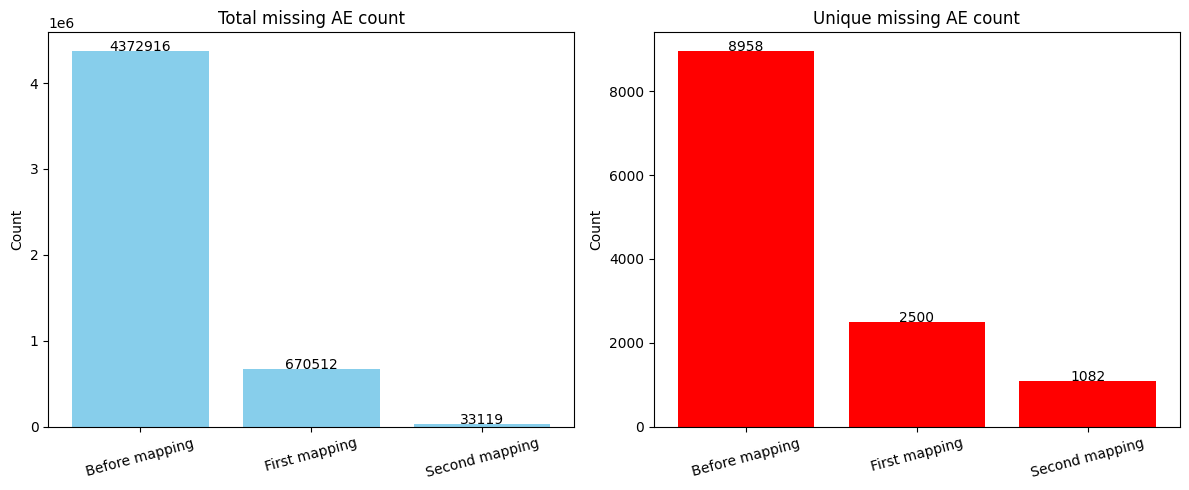

In [83]:
before_mapping = data_3.explode('pt', ignore_index=True)
first_mapping = pd.read_csv('data/faers_adalimumab_2020-2024_ungrouped_cleaned_1.csv')
first_mapping = first_mapping[first_mapping['SOC'].isna()]
second_mapping = pd.read_csv('data/faers_adalimumab_2020-2024_ungrouped_cleaned_2.csv')
second_mapping = second_mapping[second_mapping['SOC'].isna()]

labels = ['Before mapping', 'First mapping', 'Second mapping']
counts = [len(before_mapping), len(first_mapping), len(second_mapping)]
unique_counts = [before_mapping['pt'].nunique(), first_mapping['pt'].nunique(), second_mapping['pt'].nunique()]

x = range(len(labels))
width = 0.35

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

# First subplot: Total count
ax1.bar(labels, counts, color='skyblue')
ax1.set_title('Total missing AE count')
ax1.set_ylabel('Count')
ax1.set_xticklabels(labels, rotation=15)

# Add count labels
for i, val in enumerate(counts):
    ax1.text(i, val + 1, str(val), ha='center')

# Second subplot: Unique pt count
ax2.bar(labels, unique_counts, color='red')
ax2.set_title('Unique missing AE count')
ax2.set_ylabel('Count')
ax2.set_xticklabels(labels, rotation=15)

# Add unique count labels
for i, val in enumerate(unique_counts):
    ax2.text(i, val + 1, str(val), ha='center')

plt.tight_layout()
plt.show()

### 11. Missing values in SOC

In [84]:
import pandas as pd
data_4 = pd.read_csv('data/faers_adalimumab_2020-2024_ungrouped_cleaned_2.csv')

In [85]:
# Create a random sample of 100 rows from the data where 'SOC' is NaN
random_pt = data_4[data_4['SOC'].isna()].copy()
random_pt = random_pt.drop_duplicates(subset=['pt'])
random_pt = random_pt['pt'].sample(n=100, random_state=0)

# Save data
random_pt.to_csv('data/random_100_pt.csv', index=False)